# EM Algorithm over sample for image segmentation 

In [29]:
import numpy as np
import random

## EM Algorithm

#### Sampling
The algorithm is aplied on a simple random sample of the total dataset.
On the final stage, in perform an extra expectation step over the total dataset
to obtain the gamas and then use them to segment the initial data.

> This notebook compares the error score of the sampled and full dataset applications. <br>
> For more details about the mathematics and the implementation as well as an example of the algotithm's iterative progression, please see the other notebook.

### Mathematics

In [30]:
def spherical_gaussian(data_m_d, mean_c_d, std_c,
                       buffer_m_d, buffer_c,
                       out_m_c):
    k = len(mean_c_d)
    # math: buffer_c = 2*std
    np.multiply(std_c, 2, out=buffer_c)
    for c in xrange(k):
        # math: buffer_m_d = -(x-m_c)^2
        np.subtract(data_m_d, mean_c_d[c], out=buffer_m_d)
        np.square(buffer_m_d, out=buffer_m_d)
        np.multiply(buffer_m_d, -1, out=buffer_m_d)
        # math: buffer_m_d = exp{ [-(x-m_c)^2] / 2*std }
        np.divide(buffer_m_d, buffer_c[c], out=buffer_m_d)
        np.exp(buffer_m_d, out=buffer_m_d)
        #  math: apply product to exp{ [-(x-m_c)^2] / 2*std }
        np.prod(buffer_m_d, axis=1, out=out_m_c.T[c])
        
    # math: buffer_c = sqrt{2*pi*std}
    np.multiply(buffer_c, np.pi, buffer_c)
    np.sqrt(buffer_c, out=buffer_c)
    # divide all by sqrt{2*pi*std} ^ k
    # iterative divisions to avoid +Inf for big k
    for c in xrange(k):
        np.divide(out_m_c, buffer_c, out=out_m_c)

    
# Batch sum to avoid very big with very small additions
def batch_sum_axis0(arr_m_k, buffer_k, out_k):
    m = len(arr_m_k)
    out_k.fill(0)
    for i in xrange(1 + m // 1000):
        start = 1000*i
        end = min(1000*(i+1), m)
        arr_m_k[start:end, :].sum(axis=0, out=buffer_k)
        np.add(out_k, buffer_k, out=out_k)
    
    
def reconstruction_error(current_m_d, initial_m_d, buffer_m_d):
    np.subtract(current_m_d, initial_m_d, out=buffer_m_d)
    np.square(buffer_m_d, out=buffer_m_d)
    return buffer_m_d.mean()

In [36]:
min_con = 0.01
min_gama = 1e-10
epsilon = 0.001
min_gama_sum = 1e-4

class EMSamled:
    def __init__(self, data, k, sample_size=10000):
        sample_size = min(sample_size, len(data))
        self.data = data
        if sample_size < len(data):
            self.sample = np.asarray(random.sample(data, sample_size))
        else:
            self.sample = data
        #self.sample = np.random.choice(data, sample_size, replace=False) if sample_size < len(data) else data
        self.k = k
        self.d = d = len(data[0])
        self.m = m = sample_size
        self.gama = np.empty((m, k))  # also known as r_ic
        self.cluster_means = np.empty((k, d))
        self.cluster_std = np.empty(k)
        self.cluster_p = np.empty(k)
        # keep old to compare for convergence test
        self.old_cluster_means = np.empty((k, d))
        self.old_cluster_std = np.empty(k)
        
        # allocate buffers for intermediate results
        self.buffer_m_d = np.empty((m, d))
        self.buffer_k_d = np.empty((k, d))
        self.buffer_c = np.empty(k)
        self.buffer_c2 = np.empty(k)
        self.buffer_d = np.empty(d)
        self.buffer_m = np.empty(m)
        self.buffer_m_int = np.empty(m, dtype=int)
        self.buffer_lendata_int = np.empty(len(data), dtype=int)
        self.buffer_lendata = np.empty(len(data))
        self.buffer_lendata_d = np.empty((len(data), d))
        self.lastgama = np.empty((len(data), k)) if sample_size < len(data) else self.gama
        
    def expectation(self):
        spherical_gaussian(self.sample, self.cluster_means, self.cluster_std,
                          self.buffer_m_d, self.buffer_c, out_m_c=self.gama)
        # mupltiply by pi
        np.multiply(self.gama, self.cluster_p, out=self.gama)
        # now normalize gama to have sum=1 for each case
        self.gama.sum(axis=1, out=self.buffer_m)
        ## but first! take care of the cases where all clusters have 0 proba
        zero_sum_cases = self.buffer_m==0  # that's a boolean array
        self.buffer_c.fill(1/(self.k+0.0))
        self.gama[zero_sum_cases] = self.buffer_c
        self.buffer_m[zero_sum_cases] = 1  # no need to normalize those
        np.divide(self.gama, self.buffer_m[None].T, out=self.gama)
        
    def last_expectation(self):
        # same as above only on the actual data rather than the sample
        m = len(self.data)
        buffer_m_d = self.buffer_lendata_d
        buffer_m = self.buffer_lendata
        spherical_gaussian(self.data, self.cluster_means, self.cluster_std,
                          buffer_m_d, self.buffer_c, out_m_c=self.lastgama)
        # mupltiply by pi
        np.multiply(self.lastgama, self.cluster_p, out=self.lastgama)
        # now normalize gama to have sum=1 for each case
        self.lastgama.sum(axis=1, out=buffer_m)
        ## but first! take care of the cases where all clusters have 0 proba
        zero_sum_cases = buffer_m==0  # that's a boolean array
        self.buffer_c.fill(1/(self.k+0.0))
        self.lastgama[zero_sum_cases] = self.buffer_c
        buffer_m[zero_sum_cases] = 1  # no need to normalize those
        np.divide(self.lastgama, buffer_m[None].T, out=self.lastgama)
        
    def maximization(self):
        # sum by batches to avoid arithmetic errors
        batch_sum_axis0(self.gama, self.buffer_c2, out_k=self.buffer_c)
        self.buffer_c[self.buffer_c==0] = min_gama_sum
        self.gama.T.dot(self.sample, out=self.cluster_means)
        np.divide(self.cluster_means, self.buffer_c[None].T, out=self.cluster_means)
        
        np.divide(self.buffer_c, self.m, out=self.cluster_p)
        assert np.abs(self.cluster_p.sum() - 1.0) < epsilon, "sum of pi is != 1.0: %r" % self.cluster_p.sum()
        for c in xrange(self.k):
            cov = np.zeros(self.d)
            np.subtract(self.sample, self.cluster_means[c], out=self.buffer_m_d)
            np.square(self.buffer_m_d, out=self.buffer_m_d)
            np.multiply(self.buffer_m_d, self.gama.T[c][None].T, out=self.buffer_m_d)
            self.buffer_m_d.sum(axis=1, out=self.buffer_m_d.T[0])
            np.divide(self.buffer_m_d.T[0], self.buffer_c[c], out=self.buffer_m_d.T[0])
            self.cluster_std[c] = max(np.sqrt(self.buffer_m_d.T[0].sum()), min_con)  
            
    def init_clusters(self):
        std = np.std(self.data, axis=0)
        mean = np.mean(self.data, axis=0)
        min_case = self.data.min(axis=0)
        max_case = self.data.max(axis=0)
        for d in xrange(self.d):
            bound = min(0.2*self.k*std[d], 2.5*std[d])
            lower_bound = -bound
            upper_bound = bound
            if lower_bound+mean[d] < min_case[d]:
                lower_bound = min_case[d]-mean[d]
            if upper_bound+mean[d] > max_case[d]:
                upper_bound = max_case[d]-mean[d]
            self.cluster_means.T[d] = np.linspace(lower_bound, upper_bound, num=self.k)
        np.add(self.cluster_means, mean, out=self.cluster_means)
        self.cluster_std[:] = 1
        self.cluster_p[:] = 1/(self.k+0.0)
    
    def converged(self):
        np.subtract(self.cluster_means, self.old_cluster_means, out=self.buffer_k_d)
        np.abs(self.buffer_k_d, out=self.buffer_k_d)
        np.subtract(self.cluster_std, self.old_cluster_std, out=self.buffer_c)
        np.abs(self.buffer_c, out=self.buffer_c)
        if self.buffer_k_d.mean() > self.d/np.sqrt(self.k):
            return False
        if self.buffer_c.mean() > self.d/np.sqrt(self.k):
            return False
        return True
    
    def em(self, repetations=3, logger=None):
        self.init_clusters()
        self.expectation()
        if logger is not None: logger(self.cluster_means, self.cluster_std, self.cluster_p, self.gama, 0, False)
        for repet in xrange(repetations):
            # swap buffers
            temp = self.cluster_means
            self.cluster_means = self.old_cluster_means
            self.old_cluster_means = temp
            temp = self.cluster_std
            self.cluster_std = self.old_cluster_std
            self.old_cluster_std = temp
            
            self.maximization()
            self.expectation()
            converged = self.converged()
            if logger is not None: logger(self.cluster_means, self.cluster_std, self.cluster_p, self.gama, repet+1, converged)
            if converged: break
                
    def segment(self, out, on_sample=False):
        if on_sample or len(self.sample) == len(self.data):
            data = self.sample
            gama = self.gama
            buffer = self.buffer_m_int
        else:
            data = self.data
            self.last_expectation()
            gama = self.lastgama
            buffer = self.buffer_lendata_int
        if out is None:
            out = np.empty(len(data))
        np.argmax(gama, axis=1, out=buffer)
        max_like = buffer
        for i in xrange(len(data)):
            out[i] = self.cluster_means[max_like[i]]
        return out

    def error(self, segmented):
        if len(segmented) == self.m:
            return reconstruction_error(self.sample, segmented, buffer_m_d=self.buffer_m_d)
        else:
            return reconstruction_error(self.data, segmented, buffer_m_d=self.buffer_lendata_d)
        
    def estimate_error(self, segment_buffer=None):
        segment_buffer = self.segment(segment_buffer, on_sample=True)
        return reconstruction_error(self.sample, segment_buffer, buffer_m_d=self.buffer_m_d)
        

## Image Application

### Load Image

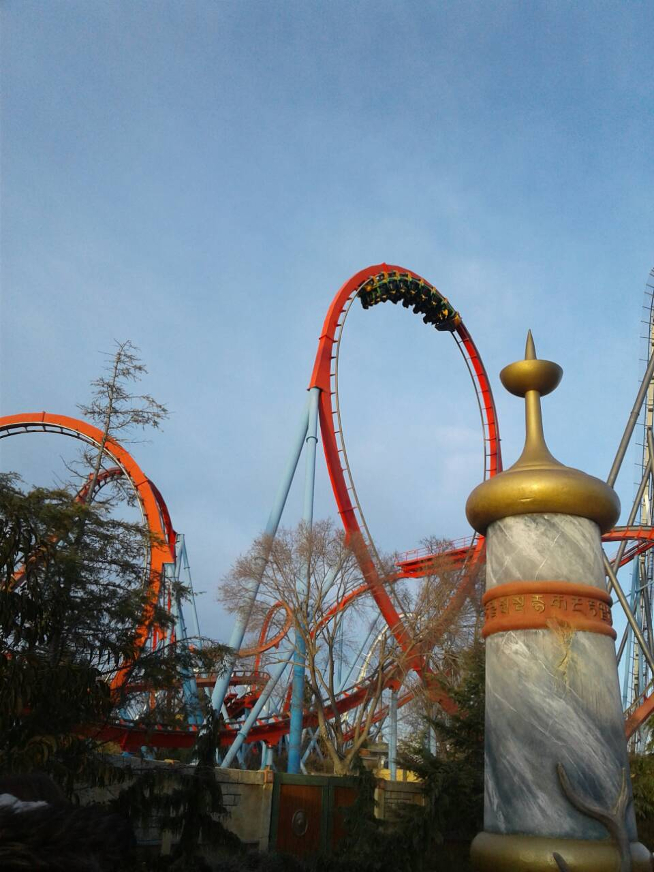

In [38]:
from PIL import Image
from IPython.display import display
from IPython.display import HTML

image = Image.open("data/traino.jpg")
image

### Test and obtain results for Ks and sample sizes

We test for K = 2, 4, 8, 16, 24, 32 <br>
and sample size = 1100, 10000, 20000, 30000, 40000, 50000

We compare the progression of the error as the sample size increases to the error when the total dataset is used (straight line)

For each sample size we run do multiple runs with different random samples and we take the mean error

WARNING: The run will take quite some time<br>
NOTE: Maximum iterations are set to 40

total dataset k = 2 done
total dataset k = 4 done
total dataset k = 8 done
total dataset k = 16 done
total dataset k = 24 done
total dataset k = 32 done


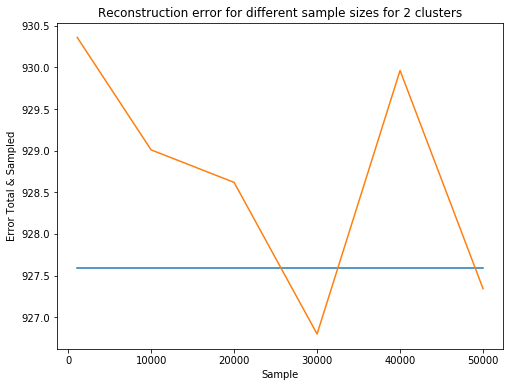

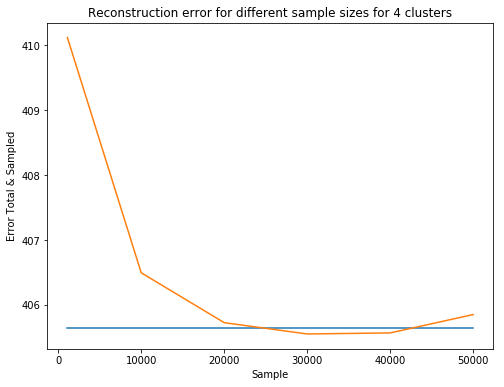

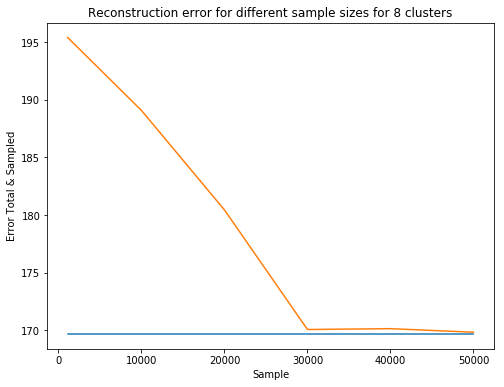

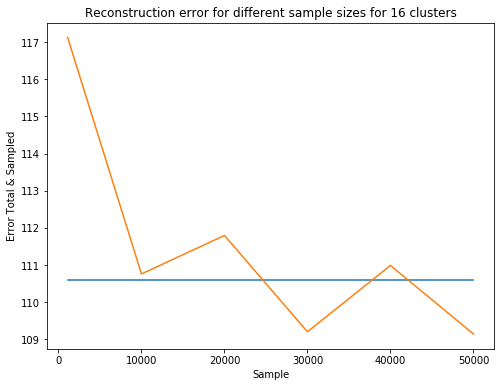

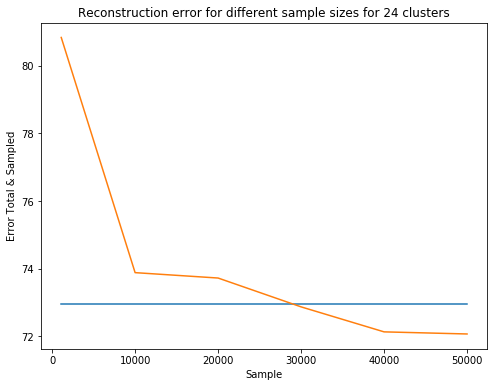

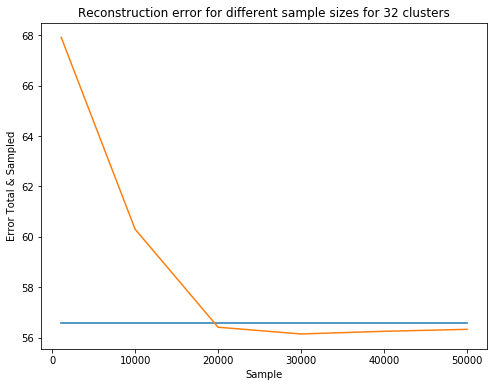

In [46]:
import pandas as pd
import os, errno
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# make directory for results
try: os.makedirs("results-sampled")
except OSError as e:
     if e.errno != errno.EEXIST: raise

results = []
KS_TO_TEST = [2, 4, 8, 16, 24, 32]
IMAGE_COMPARISSON_HEIGHT = 1050
image_comparisson_width = int(np.ceil((float(IMAGE_COMPARISSON_HEIGHT) / ((len(KS_TO_TEST)+1) // 2)) * 2 * (float(image.width) / image.height)))
image_comparisson = Image.new("RGB", (image_comparisson_width, IMAGE_COMPARISSON_HEIGHT))
SAMPLE_SIZES_TO_TEST = [1100, 10000, 20000, 30000, 40000, 50000]

y = 0
buffer_segment = np.empty((len(data_flat), 3))
for i, k in enumerate(KS_TO_TEST):
    result = pd.DataFrame(columns=['Clusters', 'Sample', 'ErrorTotal', 'ErrorSample'])
    em = EMSamled(data_flat, k, len(data_flat))
    em.em(40)
    em.segment(buffer_segment)
    err_total = em.error(buffer_segment)
    print 'total dataset k =', k, 'done'
    for sample_size in SAMPLE_SIZES_TO_TEST:
        # we do  diferent samplings
        err = 0
        for j in range(5):
            em = EMSamled(data_flat, k, sample_size)
            em.em(40)
            em.segment(buffer_segment)
            err = err + em.error(buffer_segment)
        result.loc[len(result)] = [k, sample_size, err_total, err/5.0]
    result.to_csv("results-sampled/k-"+str(k)+"s.csv",sep = ',')
    results.append(result)
i = 0
for res, k in zip(results, KS_TO_TEST):
    plt.figure(i, (8, 6))
    i = i+1
    plt.plot(res['Sample'], res['ErrorTotal'])
    plt.plot(res['Sample'], res['ErrorSample'])
    plt.xlabel('Sample')
    plt.ylabel('Error Total & Sampled')
    plt.title('Reconstruction error for different sample sizes for '+str(k)+' clusters')

## Weaknesses

### Known logical imlementation errors
The algorithms sometimes gives higher error on iterations that happen after it has converged.
The magnitude of the difference is very small to be noticed by naked eye

### Limits
The algorithm, on the application of image segmentation behaves well for values of k at most around 180.
For k=256, for example, it merges most of the clusters into a single cluster with the same mean and std